In [1]:
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE" # on NERSC filelocking is not allowed
import h5py
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
import pickle as pkl

import tensorflow as tf
# Make notebook run on other GPUS. GPT's solution ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[1], 'GPU')  # change 1 to 0, 2, 3 as needed
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

import sys
# Path to dir model.py lives in -------
# NOTE: This needs to be modified to where your repo lives, path to /repo/path/VAE_FS/models/
# If the jupyter notebook kernel is running from VAE_FS/models/ the
# line below is not needed
sys.path.append('/global/homes/j/jananinf/projs/VAE_FS/models/')

# import the custom models and functions
from models import Qmake_encoder_set_weights, Qmake_decoder_set_weights
# in gan1. We train the VAE_GAN model

2025-07-21 12:06:21.467191: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-21 12:06:24.860436: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instead of importing we will define the model in house

In [2]:
def Qmake_discriminator(input_dim, h_dim_1, h_dim_2):
    l2_factor = 1e-3
    inputs = keras.Input(shape=(input_dim))
    x = Dense(h_dim_1,
              activation='relu',
              kernel_initializer=keras.initializers.HeNormal(seed=None),
              bias_initializer=keras.initializers.Zeros())(inputs)
    x = Dense(h_dim_2,
              activation='relu',
              kernel_initializer=keras.initializers.HeNormal(seed=None),
              bias_initializer=keras.initializers.Zeros())(x)
    x = Dense(1,
              activation='sigmoid',  # Output probability
              kernel_initializer=keras.initializers.HeNormal(seed=None),
              bias_initializer=keras.initializers.Zeros())(x)
    discriminator = keras.Model(inputs, x, name='discriminator')
    return discriminator
def custom_mse_loss_with_multi_index_scaling(masked_data, masked_reconstruction):
    jet_scale = 1
    tau_scale = 1
    muon_sacle = 1
    met_scale = 1

    # Define the indices and their corresponding scale factors
    scale_dict = {
        0: jet_scale,
        3: jet_scale,
        6: jet_scale,
        9: jet_scale,
        12: jet_scale,
        15: jet_scale,
        18: tau_scale,
        21: tau_scale,
        24: tau_scale,
        27: tau_scale,
        30: muon_sacle,
        33: muon_sacle,
        36: muon_sacle,
        39: muon_sacle,
        42: met_scale
    }
    
    # Create the scaling tensor
    scale_tensor = tf.ones_like(masked_data)
    
    for index, factor in scale_dict.items():
        index_mask = tf.one_hot(index, depth=tf.shape(masked_data)[-1])
        scale_tensor += index_mask * (factor - 1)
    
    # Apply scaling
    scaled_data = masked_data * scale_tensor
    scaled_reconstruction = masked_reconstruction * scale_tensor
    
#     # Hardcoded lists for eta and phi indices
#     eta_indices = [1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40]
#     phi_indices = [2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 43]

#     batch_size = tf.shape(scaled_reconstruction)[0]
    
#     # Apply constraints to eta
#     for i in eta_indices:
#         indices = tf.stack([tf.range(batch_size), tf.fill([batch_size], i)], axis=1)
#         updates = 3 * tf.tanh(scaled_reconstruction[:, i] / 3)
#         scaled_reconstruction = tf.tensor_scatter_nd_update(scaled_reconstruction, indices, updates)
    
#     # Apply constraints to phi
#     for i in phi_indices:
#         indices = tf.stack([tf.range(batch_size), tf.fill([batch_size], i)], axis=1)
#         updates = 3.14159265258979*(10/8) * tf.tanh(scaled_reconstruction[:, i] / (3.14159265258979*(10/8)))
#         scaled_reconstruction = tf.tensor_scatter_nd_update(scaled_reconstruction, indices, updates)
    # Calculate MSE using keras.losses.mse
    mse = keras.losses.mse(scaled_data, scaled_reconstruction)
    
    # Take the mean across all dimensions
    return tf.reduce_mean(mse)

class VAE_GAN_Model(keras.Model):
    def __init__(self, encoder, decoder, discriminator, steps_per_epoch=20,cycle_length=20, min_beta=0, max_beta=1,min_gamma=0, max_gamma=1, max_epochs = 100, **kwargs):
        super().__init__(**kwargs)
        self.max_epochs = max_epochs # Max number of epochs the model is going to be trained over

        self.encoder = encoder
        self.decoder = decoder
        self.discriminator = discriminator

        # per keras VAE example https://keras.io/examples/generative/vae/
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

        self.discriminator_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        self.gamma_tracker = keras.metrics.Mean(name="gamma")


        self.beta_tracker = keras.metrics.Mean(name="beta")
        self.steps_per_epoch = steps_per_epoch
        self.cycle_length = tf.cast(cycle_length, tf.float32)
        self.min_beta = tf.cast(min_beta, tf.float32)
        self.max_beta = tf.cast(max_beta, tf.float32)
        self.beta = tf.Variable(min_beta, dtype=tf.float32)

        self.min_gamma = tf.cast(min_gamma, tf.float32)
        self.max_gamma = tf.cast(max_gamma, tf.float32)
        self.gamma = tf.Variable(min_gamma, dtype=tf.float32)

    def compile(self, optimizer, **kwargs):
        super(VAE_GAN_Model, self).compile(**kwargs)
        # Set the optimizer for the entire model (encoder + decoder + discriminator)
        self.optimizer = optimizer

        # Collect trainable variables from encoder, decoder, and discriminator
        trainable_variables = (
            self.encoder.trainable_weights + 
            self.decoder.trainable_weights + 
            self.discriminator.trainable_weights
        )
        # Build the optimizer with the full variable list
        self.optimizer.build(trainable_variables)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.discriminator_loss_tracker,
            self.beta_tracker,
        ]

    def cyclical_annealing_beta(self, epoch):
        cycle = tf.floor(1.0 + epoch / self.cycle_length)
        x = tf.abs(epoch / self.cycle_length - cycle + 1)
        # For first half (x < 0.5), scale 2x from 0 to 1
        # For second half (x >= 0.5), stay at 1
        scaled_x = tf.where(x < 0.5, 2.0 * x, 1.0)
        return self.min_beta + (self.max_beta - self.min_beta) * scaled_x
    
    # def cyclical_annealing_beta(self, epoch):
    #     # Get position within current cycle (0 to cycle_length)
    #     cycle_position = tf.math.mod(epoch, self.cycle_length)
        
    #     # For first half of cycle, increase linearly
    #     # For second half, stay at max
    #     half_cycle = self.cycle_length / 2
    #     scaled_x = tf.where(cycle_position <= half_cycle,
    #                     cycle_position / half_cycle,  # Linear increase in first half
    #                     1.0)                         # Stay at max for second half
        
    #     return self.min_beta + (self.max_beta - self.min_beta) * scaled_x


    # def get_gamma_schedule(self, epoch):
    #     # Convert to float32 for TF operations
    #     epoch = tf.cast(epoch, tf.float32)
        
    #     # Calculate annealing progress
    #     anneal_progress = (epoch - 50.0) / 50.0
    #     gamma_anneal = self.min_gamma + (self.max_gamma - self.min_gamma) * anneal_progress
        
    #     # Implement the conditions using tf.where
    #     gamma = tf.where(epoch < 50.0, 
    #                     0.0,  # if epoch < 50
    #                     tf.where(epoch >= 100.0,
    #                             self.max_gamma,  # if epoch >= 100
    #                             gamma_anneal))   # if 50 <= epoch < 100
        
    #     return gamma

    def get_gamma_schedule(self, epoch):
        # Convert to float32 for TF operations
        epoch = tf.cast(epoch, tf.float32)
        
        # Calculate annealing progress
        anneal_progress = (epoch - 0.0) / self.max_epochs
        gamma_anneal = self.min_gamma + (self.max_gamma - self.min_gamma) * anneal_progress
        # slope = (self.max_gamma -  self.min_gamma)/self.max_epochs

        return gamma_anneal


    def train_step(self, data):
        # Is this the beta tuning?
        epoch = tf.cast(self.optimizer.iterations / self.steps_per_epoch, tf.float32)
        
        # Update beta
        self.beta.assign(self.cyclical_annealing_beta(epoch))
        self.gamma.assign(self.get_gamma_schedule(epoch))

        # ---------------------------
        # Train the Discriminator
        # ---------------------------
        with tf.GradientTape() as tape_disc:
            # Generate reconstructed data
            mask = K.cast(K.not_equal(data, 0), K.floatx())
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            # Get discriminator predictions
            real_output = self.discriminator(data)
            fake_output = self.discriminator(reconstruction * mask)
            
            # Labels for real and fake data
            real_labels = tf.ones_like(real_output)
            fake_labels = tf.zeros_like(fake_output)
            
            # Discriminator loss
            d_loss_real = keras.losses.binary_crossentropy(real_labels, real_output)
            d_loss_fake = keras.losses.binary_crossentropy(fake_labels, fake_output)
            d_loss = d_loss_real + d_loss_fake
            d_loss = tf.reduce_mean(d_loss)
        
        grads_disc = tape_disc.gradient(d_loss, self.discriminator.trainable_weights)
        self.optimizer.apply_gradients(zip(grads_disc, self.discriminator.trainable_weights))

        # ---------------------------
        # Train the VAE (Generator)
        # ---------------------------
        with tf.GradientTape() as tape:
            # Giving clean data here versus noisy in the atlas version
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # here we shove in our custom reconstructionn loss function
            # Ignore zero-padded entries. 
            mask = K.cast(K.not_equal(data, 0), K.floatx()) 
            reconstruction_loss = custom_mse_loss_with_multi_index_scaling(mask*reconstruction, mask*data)
            reconstruction_loss *=(1-self.beta)

            # This is just standard Kullback-Leibler diversion loss. I think this can stay.
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *=self.beta

            # Generator (VAE) wants to fool the discriminator
            fake_output = self.discriminator(mask*reconstruction)
            valid_labels = tf.ones_like(fake_output)  # Try to make discriminator think reconstructions are real
            g_loss_adv = keras.losses.binary_crossentropy(valid_labels, fake_output)
            g_loss_adv = tf.reduce_mean(g_loss_adv)

            # curr_training_gamma = self.gamma * (epoch / 50)  # TODO 50 is arbitrary based on max_epochs # Not sure what this is doing.
            
            total_loss = reconstruction_loss + kl_loss + g_loss_adv * self.gamma

        # ----- Review for differences
        # grads = tape.gradient(total_loss, self.trainable_weights)
        # self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # self.total_loss_tracker.update_state(total_loss)
        # self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        # self.kl_loss_tracker.update_state(kl_loss)

        grads_vae = tape.gradient(total_loss, self.encoder.trainable_weights + self.decoder.trainable_weights)
        self.optimizer.apply_gradients(zip(grads_vae, self.encoder.trainable_weights + self.decoder.trainable_weights)) # This line is different
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.discriminator_loss_tracker.update_state(g_loss_adv)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reco_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "disc_loss": self.discriminator_loss_tracker.result(),
            "beta": self.beta,
            "raw_loss": self.reconstruction_loss_tracker.result() + self.kl_loss_tracker.result(),
            "w_kl_loss": self.kl_loss_tracker.result() * self.beta,
            "w_disc_loss": self.discriminator_loss_tracker.result() * self.gamma,
            "gamma": self.gamma,
        }
    
    # Since we overrode train_step we need test_step
    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        mask = K.cast(K.not_equal(data, 0), K.floatx())
        reconstruction_loss = custom_mse_loss_with_multi_index_scaling(mask*data, mask*reconstruction)

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(kl_loss)
        # Discriminator loss (only for monitoring)
        # pass both data and reconstruction through D to get generator adversarial loss
        real_output = self.discriminator(data)
        fake_output = self.discriminator(mask*reconstruction)
        real_labels = tf.ones_like(real_output)
        fake_labels = tf.zeros_like(fake_output)
        d_loss_real = keras.losses.binary_crossentropy(real_labels, real_output)
        d_loss_fake = keras.losses.binary_crossentropy(fake_labels, fake_output)
        d_loss = d_loss_real + d_loss_fake
        d_loss = tf.reduce_mean(d_loss)
        
        # Generator adversarial loss
        valid_labels = tf.ones_like(fake_output)
        g_loss_adv = keras.losses.binary_crossentropy(valid_labels, fake_output)
        g_loss_adv = tf.reduce_mean(g_loss_adv)
        total_loss = reconstruction_loss + kl_loss * self.beta + g_loss_adv * self.gamma
        
        return {
            "loss": total_loss,
            "reco_loss": reconstruction_loss,
            "kl_loss": kl_loss,
            "raw_loss": reconstruction_loss + kl_loss,
            "disc_loss": g_loss_adv,
            "w_kl_loss": kl_loss * self.beta,
            "w_disc_loss": g_loss_adv * self.gamma,
            "gamma": self.gamma
        }


    def call(self, data):
        z_mean,z_log_var,x = self.encoder(data)
        reconstruction = self.decoder(x)
        return {
            "z_mean": z_mean,
            "z_log_var": z_log_var,
            "reconstruction": reconstruction
        }


In [3]:
# Load data
home_path = "/global/cfs/cdirs/m2616/jananinf/projsIO/VAE_FS/" # Updated to NERSC
file_path = home_path + "preprocessed_SNL_data.h5"
with h5py.File(file_path, 'r') as hf:           # Shapes:
    X_train = hf['X_train'][:]                  # (3200000, 57)
    X_test  = hf['X_test'][:]                   # (800000,  57)
    Ato4l_data  = hf['Ato4l_data'][:]           # (55969,   57) Signal data 
    hToTauTau_data  = hf['hToTauTau_data'][:]   # (691283,  57) ""
    hChToTauNu_data  = hf['hChToTauNu_data'][:] # (760272,  57) ""
    leptoquark_data = hf['leptoquark_data'][:]  # (340544,  57) ""
    print("Data loaded from preprocessed_SNL_data.h5")

Data loaded from preprocessed_SNL_data.h5


In [4]:
INPUT_SZ = 57
H1_SZ = 32
H2_SZ = 16
LATENT_SZ = 3
NUM_EPOCHS = 100
BATCH_SIZE = 1024
STOP_PATIENCE = 40
LR_PATIENCE = 20


### Simple training loop. No parameter sweeping

In [10]:
train = True
NUM_TRAIN = 10 
save = True
SAVE_PATH = home_path+f"/GAN_trainings/attempt6/" #
# Next attempt should go to 2
# Attempt History. The original code for each folder should also be tied to the commits. 
# 0: First attempt. GAN as copied from other repo https://github.com/max-cohen54/AD_trigger_training/blob/main/L1AD/software/VAE_GAN/L1_VAE_Analyzer_FDL_GAN_ALT.ipynb
# 1: Added GAN loss to 
# 2: Various parametric sweeps
# 3: Better file naming convention and varied clipnorm
# Notes: Smaller clipnorm ~ 0.1 tended to bring down the losses rather than blowing up.
# Keeping clipnorm to 0.1 in future trainings
# 4: Varying gamma maxes
# 5: gamma = 0 sanity check
# 6: Changed Discriminator to 8, 2 for hidden layers as in https://github.com/max-cohen54/AD_trigger_training/blob/main/L1AD/software/VAE_GAN/L1_VAE_Analyzer_FDL_GAN_ALT.ipynb
## No longer sweeping for now.

early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=LR_PATIENCE, verbose=1)

for i in range(NUM_TRAIN):
    if train:
        tf.keras.backend.clear_session()

        print(f"TRAINING ITERATION {i} ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
        enc = Qmake_encoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
        dec = Qmake_decoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
        disc = Qmake_discriminator(INPUT_SZ, 8, 2) # Modified this to the ATLAS-VAE-GAN

        steps_per_epoch = X_train.shape[0] // BATCH_SIZE
        
        # Modified these setting to match atlas VAE gan repo
        vae = VAE_GAN_Model(enc, dec, disc, cycle_length=20, min_beta=0, max_beta=1, min_gamma=1, max_gamma=50)
        opt = keras.optimizers.Adam(learning_rate=0.001)
        # --
        vae.compile(optimizer=opt)
        history = vae.fit(x=X_train, validation_split=0.2, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping,reduce_lr], shuffle=True)

        
        # Iterative training. 
        save_path = SAVE_PATH+f"n_{i}/" 
        if save:
            print(f"SAVING ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
            vae.save_weights(filepath=save_path, save_format='tf')

            # Now save the histories
            with open(save_path + f"training_history.pkl", 'wb') as f:
                pkl.dump(history.history, f)
            
            #TODO: Save entire training history.

TRAINING ITERATION 0 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



2025-07-21 12:17:58.155376: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38366 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0


Epoch 1/100


2025-07-21 12:18:00.371973: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-07-21 12:18:00.589317: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f88c4029a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-21 12:18:00.589338: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-07-21 12:18:00.628167: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-21 12:18:00.700233: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2025-07-21 12:18:00.900565: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

2500/2500 [==============================] - 15s 4ms/step - loss: 1020452.0403 - reco_loss: 3.0860 - kl_loss: 893974.6250 - disc_loss: 0.8839 - beta: 0.9900 - raw_loss: 1020434.6545 - w_kl_loss: 741378.2436 - w_disc_loss: 60.6287 - gamma: 62.2500 - val_loss: 88.1875 - val_reco_loss: 2.3495 - val_kl_loss: 0.2471 - val_raw_loss: 2.5966 - val_disc_loss: 0.6933 - val_w_kl_loss: 0.2447 - val_w_disc_loss: 85.5934 - val_gamma: 123.4510 - lr: 0.0010
Epoch 2/100
2500/2500 [==============================] - 10s 4ms/step - loss: 582710.5234 - reco_loss: 527054.8496 - kl_loss: 68279.3281 - disc_loss: 0.6956 - beta: 1.0000 - raw_loss: 582605.5400 - w_kl_loss: 41291.8340 - w_disc_loss: 128.6066 - gamma: 184.7500 - val_loss: 185.2409 - val_reco_loss: 2.3111 - val_kl_loss: 0.1837 - val_raw_loss: 2.4948 - val_disc_loss: 0.7430 - val_w_kl_loss: 0.1837 - val_w_disc_loss: 182.7461 - val_gamma: 245.9510 - lr: 0.0010
Epoch 3/100
2500/2500 [==============================] - 11s 4ms/step - loss: 4655.3019 - r

Moving over to large parametric sweep to find something that will work

In [7]:
from matplotlib import pyplot as plt
# NUM_TRAIN = 4 # Train just once for now
SAVE_PATH = home_path+f"GAN_trainings/attempt6/" #
train = False
save = True
NUM_TRAIN = 3 # Train just once for now
# Next attempt should go to 2
# Attempt History. The original code for each folder should also be tied to the commits. 
# 0: First attempt. GAN as copied from other repo https://github.com/max-cohen54/AD_trigger_training/blob/main/L1AD/software/VAE_GAN/L1_VAE_Analyzer_FDL_GAN_ALT.ipynb
# 1: Added GAN loss to 
# 2: Various parametric sweeps
# 3: Better file naming convention and varied clipnorm
# Notes: Smaller clipnorm ~ 0.1 tended to bring down the losses rather than blowing up.
# Keeping clipnorm to 0.1 in future trainings
# 4: Varying gamma maxes
# 5: gamma = 0 sanity check
# 6: Changed Discriminator to 8, 2 for hidden layers as in https://github.com/max-cohen54/AD_trigger_training/blob/main/L1AD/software/VAE_GAN/L1_VAE_Analyzer_FDL_GAN_ALT.ipynb
## No longer sweeping for now.


early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=LR_PATIENCE, verbose=1)

parameters = [0]
parameters_key = "max_gamma"
SAVE_PATH = SAVE_PATH + parameters_key + "/"

n_train = 3 # Train at least 3 models per parameter

if train:
    for param in parameters:
        for i in range(n_train):
            save_path = SAVE_PATH + f"{parameters_key}_{param}/"

            # Manually make the directories and file. Python can do it, but its cleaner to do it manually
            with open(SAVE_PATH +"out.txt", "a") as f:
                print(f"Variant: {parameters_key} = {param} TRAINING ITERATION {i} ~~~~~~~~~~~\n", file=f)


            tf.keras.backend.clear_session()

            enc = Qmake_encoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
            dec = Qmake_decoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
            disc = Qmake_discriminator(INPUT_SZ, 8, 2) # Testing out these values for now

            steps_per_epoch = X_train.shape[0] // BATCH_SIZE
            vae = VAE_GAN_Model(enc, dec, disc, cycle_length=20, min_beta=0, max_beta=1, min_gamma=1, max_gamma=50)
            opt = keras.optimizers.Adam(learning_rate=0.001) 
            history = vae.fit(x=X_train, validation_split=0.2, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping,reduce_lr], shuffle=True)

            # Make loss plot
            plt.figure(figsize=(12, 8))
            # Plot training losses
            for key, val in history.history.items():
                if key == 'lr':
                    continue
                plt.plot(val, label=key, 
                        linestyle = "dashed" if key[0:3] == 'val' else "solid") 
                
            # Customize the plot
            plt.title(f'Variant: {parameters_key} = {param} Training and Validation Losses Run: {i}')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            plt.semilogy()

            # # Show the plot
            # plt.show()
            
            # Iterative training. 
            # save_path = save_path + f"n_{i}/" # As of 7/8/25. Should be synced with vae0_analysis
            if save:
                iter_save_path = save_path +  f"n_{i}/"

                # Save progress to main out file
                with open(SAVE_PATH + "out.txt", "a") as f: 
                    print(f"SAVING Variant: {parameters_key} = {param} TRAINING ITERATION {i} ~~~~~~~~~~~\n Save path: {iter_save_path}\n", file=f, flush = True)

                # Save weights to iter specific folder
                vae.save_weights(filepath=iter_save_path , save_format='tf')
                # Now save the histories
                with open(iter_save_path + f"training_history.pkl", 'wb') as f:
                    pkl.dump(history.history, f)
                plt.savefig(iter_save_path + parameters_key + f"_{param}.png")




Plot Loss vs epoch history.

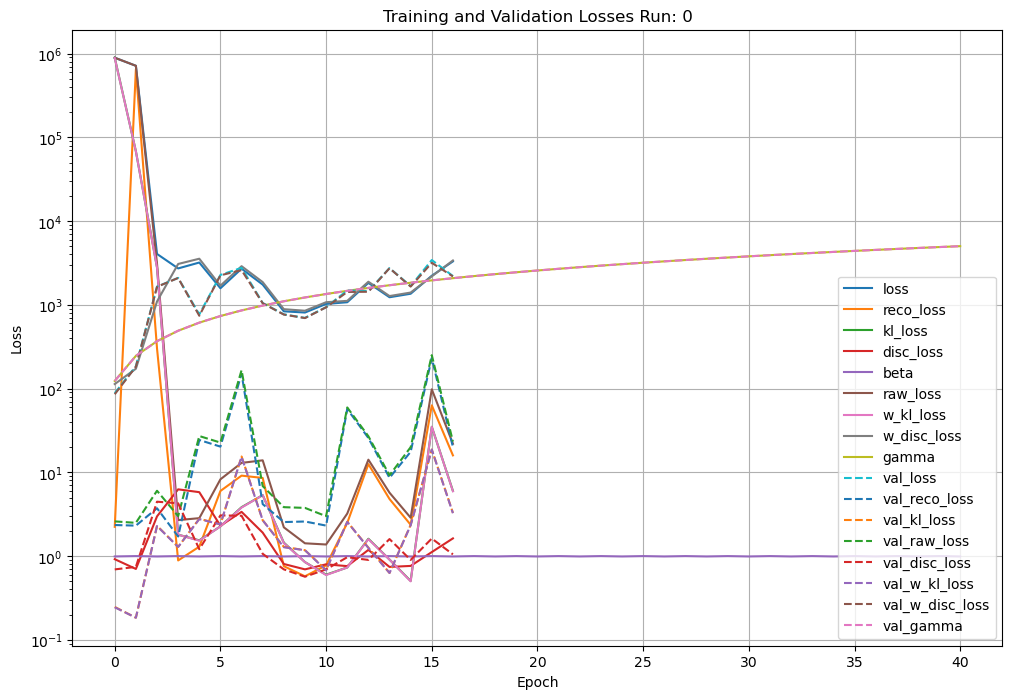

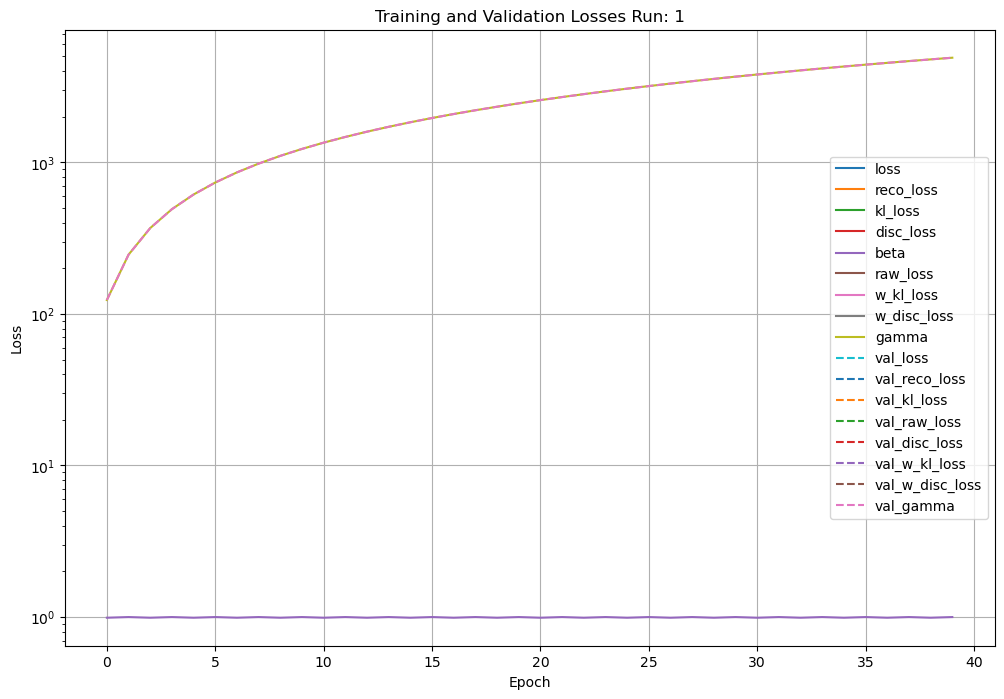

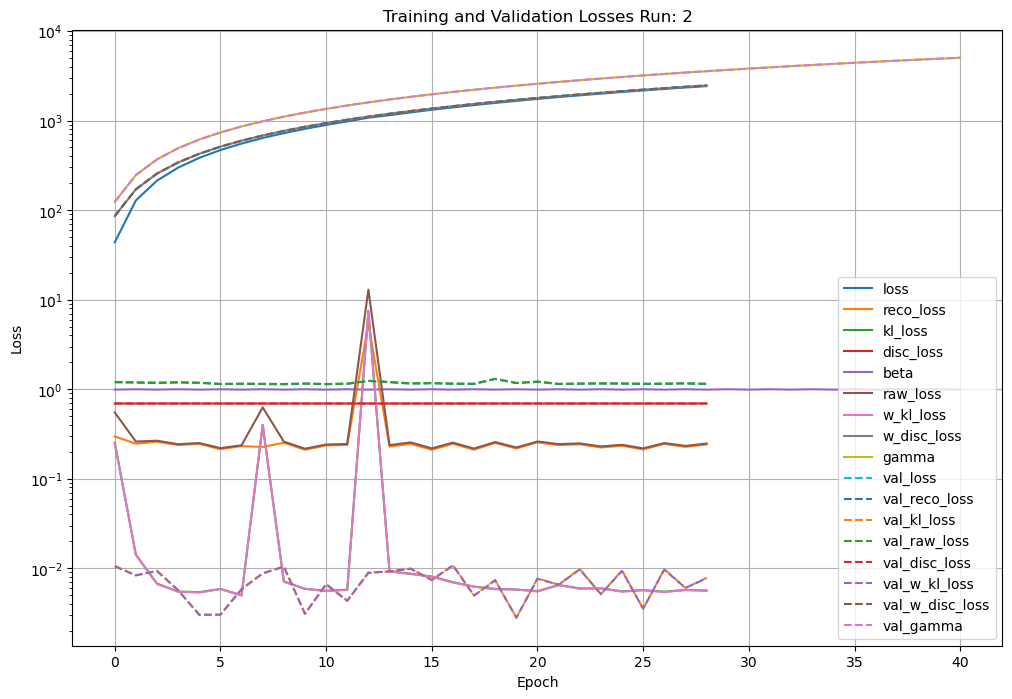

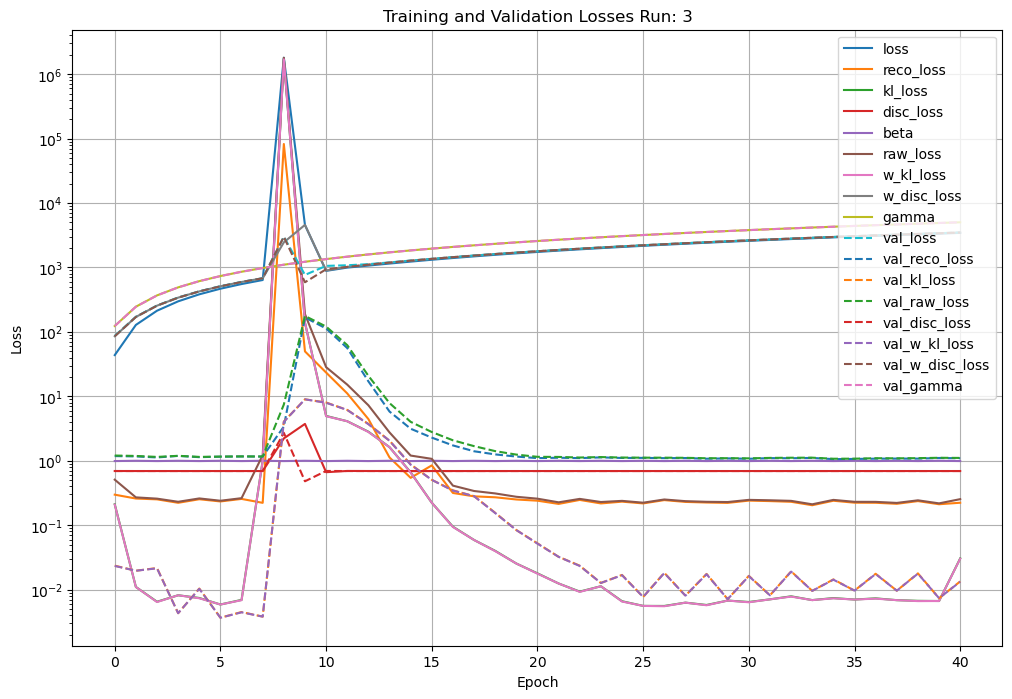

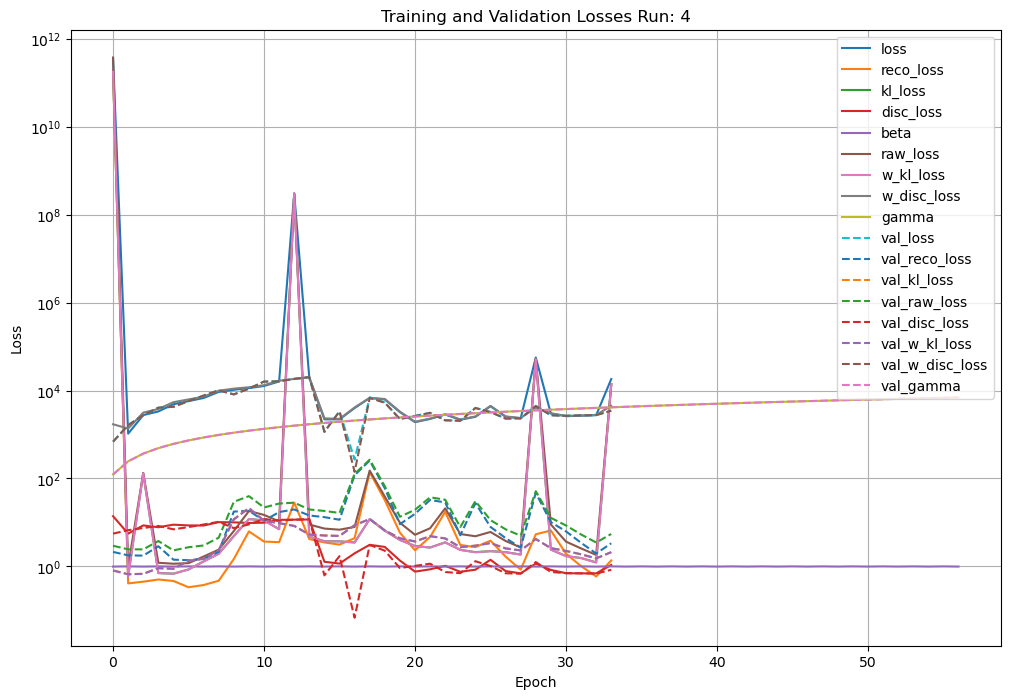

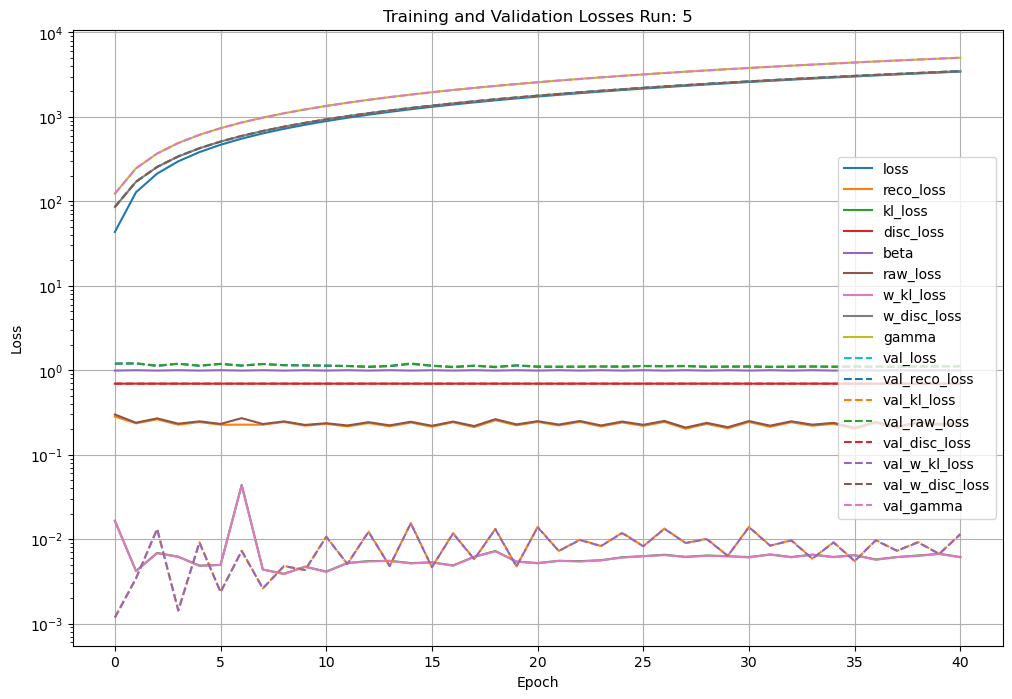

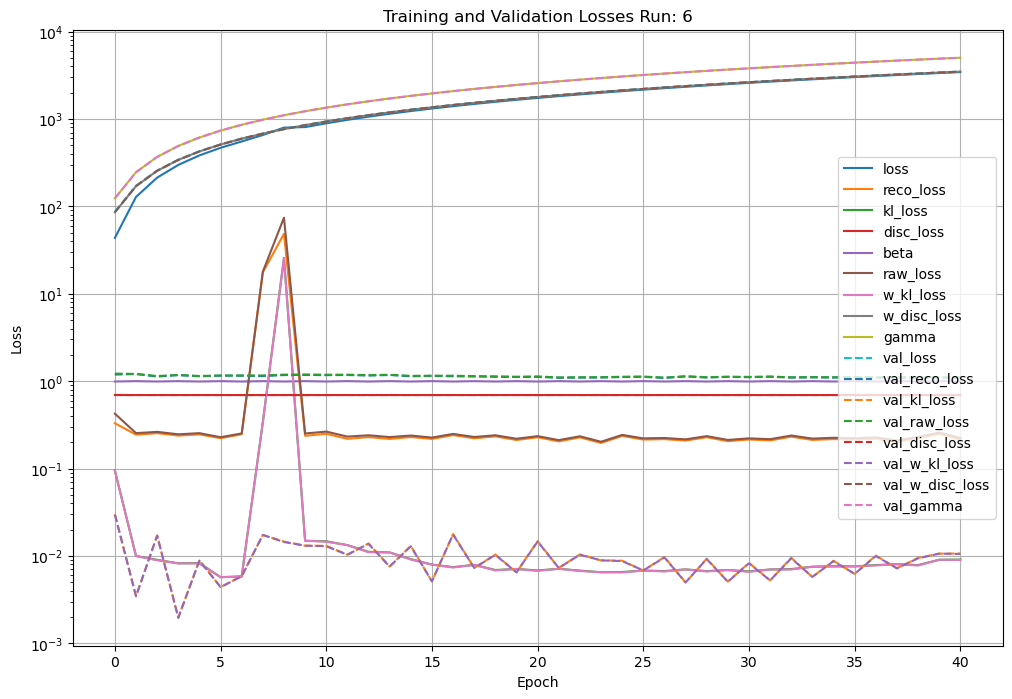

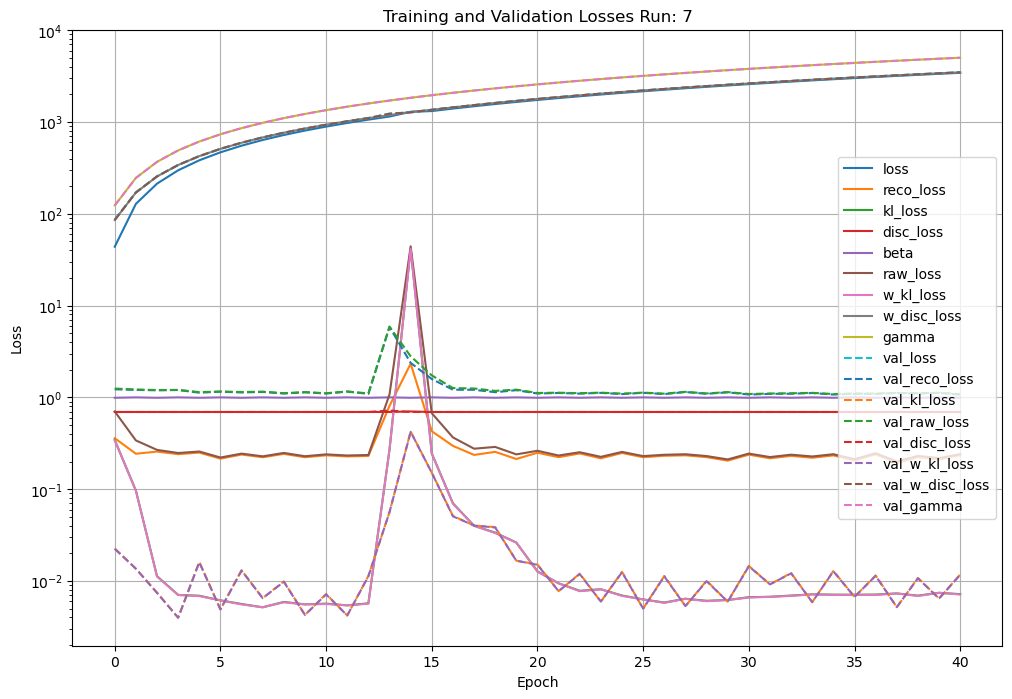

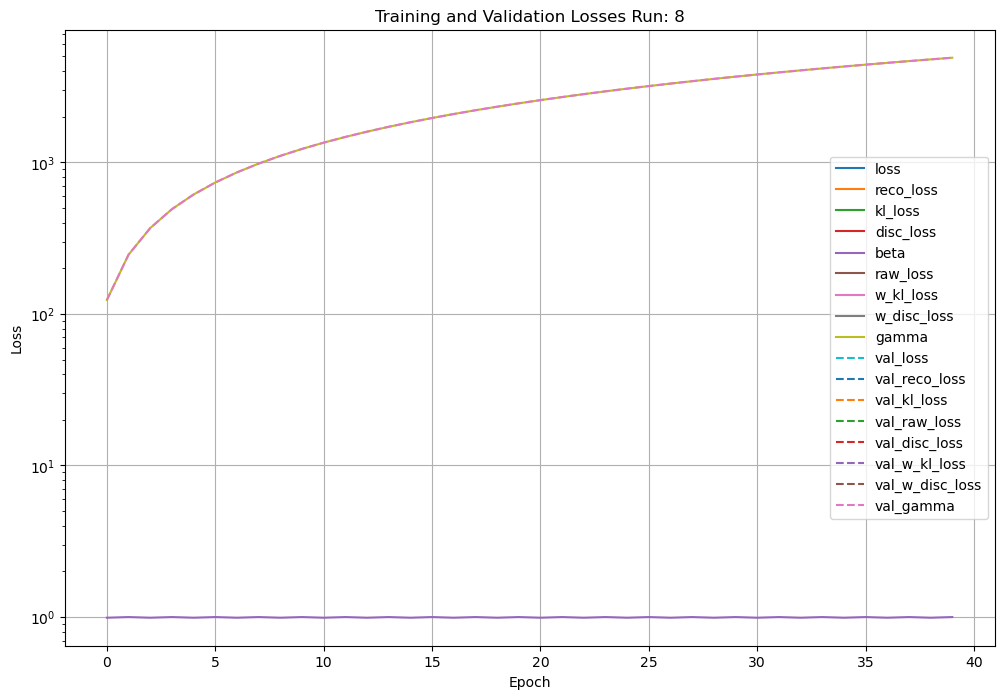

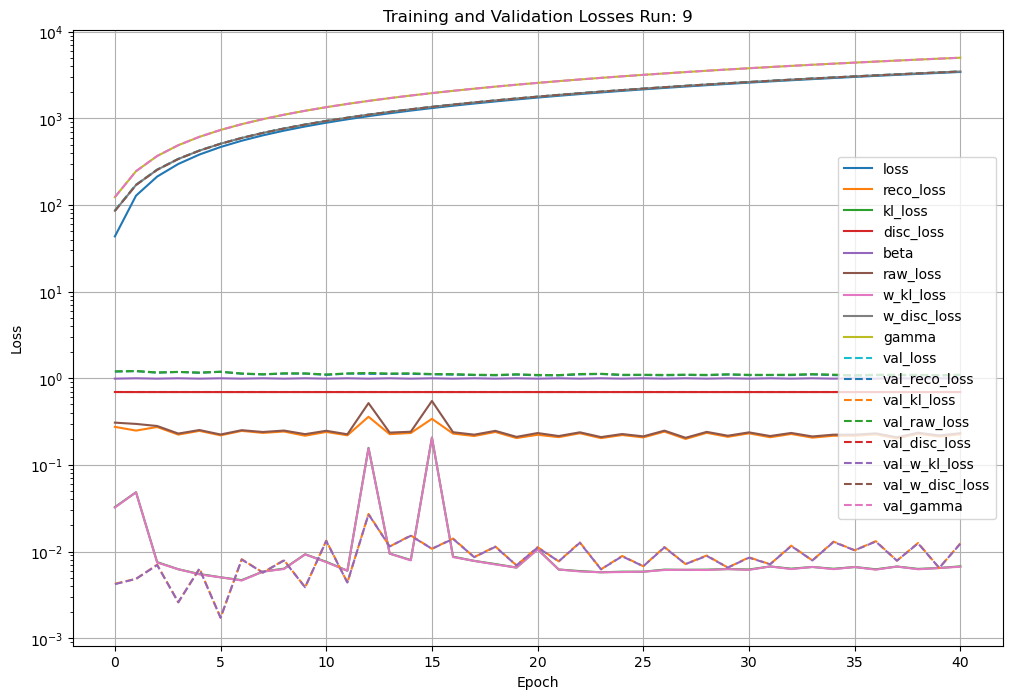

In [11]:
import matplotlib.pyplot as plt
import pickle as pkl
# Assuming 'history' is the object returned by your model.fit() call

for i in range(NUM_TRAIN):
    save_path = SAVE_PATH + f"n_{i}/"
    with open(save_path + 'training_history.pkl', 'rb') as f:
        history = pkl.load(f)

    # Extract the loss values
    total_loss = history['loss']
    reco_loss = history['reco_loss']
    kl_loss = history['kl_loss']
    val_total_loss = history['val_loss']
    val_reco_loss = history['val_reco_loss']
    val_kl_loss = history['val_kl_loss']
    gamma = history['gamma']

    # Create a new figure
    plt.figure(figsize=(12, 8))

    # Plot training losses
    for key, val in history.items():
        if key == 'lr':
            continue
        plt.plot(val, label=key, 
                 linestyle = "dashed" if key[0:3] == 'val' else "solid") 
    # plt.plot(total_loss, label='Total Loss', color='blue')
    # plt.plot(reco_loss, label='Reconstruction Loss', color='green')
    # plt.plot(kl_loss, label='KL Loss', color='red')

    # plt.plot(history['beta'],label="beta")
    # plt.plot(history['gamma'], label="$\gamma$")

    # # Plot validation losses
    # plt.plot(val_total_loss, label='Val Total Loss', color='blue', linestyle='--')
    # plt.plot(val_reco_loss, label='Val Reconstruction Loss', color='green', linestyle='--')
    # plt.plot(val_kl_loss, label='Val KL Loss', color='red', linestyle='--')

    # Customize the plot
    plt.title(f'Training and Validation Losses Run: {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.semilogy()

    # Show the plot
    plt.show()

In [10]:
# What do we want as a AD metric? the discriminator or latent space vars